In [1]:
import numpy as np
import os
import six.moves.urllib as urllib
import sys
import tarfile
import tensorflow as tf
import zipfile
import pandas as pd
from distutils.version import StrictVersion
from collections import defaultdict
from io import StringIO
from matplotlib import pyplot as plt
from PIL import Image
from utils import label_map_util
from utils import visualization_utils as vis_util
# This is needed since the notebook is stored in the object_detection folder.
sys.path.append("..")
from object_detection.utils import ops as utils_ops
from os import listdir
from os.path import isfile, join
%matplotlib inline


/Users/oly/anaconda3/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/Users/oly/anaconda3/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/Users/oly/anaconda3/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/Users/oly/anaconda3/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:5

# Model preparation 

In [2]:
model_name = 'inference_graph'
path_to_frozen_graph = model_name + '/frozen_inference_graph.pb'
path_to_labels = 'training/labelmap.pbtxt'

## Load a (frozen) Tensorflow model into memory.

In [3]:
detection_graph = tf.Graph()
with detection_graph.as_default():
    od_graph_def = tf.GraphDef()
    with tf.gfile.GFile(path_to_frozen_graph, 'rb') as fid:
        serialized_graph = fid.read()
        od_graph_def.ParseFromString(serialized_graph)
        tf.import_graph_def(od_graph_def, name='')

In [4]:
category_index = label_map_util.create_category_index_from_labelmap(path_to_labels, use_display_name=True)

## Helper code

In [5]:
def load_image_into_numpy_array(image):
  (im_width, im_height) = image.size
  return np.array(image.getdata()).reshape(
      (im_height, im_width, 3)).astype(np.uint8)

# Detection

In [6]:
def run_inference_for_single_image(image, graph):
    with graph.as_default():
        with tf.Session() as sess:
        # Get handles to input and output tensors
            ops = tf.get_default_graph().get_operations()
            all_tensor_names = {output.name for op in ops for output in op.outputs}
            tensor_dict = {}
            for key in ['num_detections', 'detection_boxes', 'detection_scores','detection_classes', 'detection_masks']:
                tensor_name = key + ':0'
                if tensor_name in all_tensor_names:
                    tensor_dict[key] = tf.get_default_graph().get_tensor_by_name(tensor_name)
            if 'detection_masks' in tensor_dict:
                # The following processing is only for single image
                detection_boxes = tf.squeeze(tensor_dict['detection_boxes'], [0])
                detection_masks = tf.squeeze(tensor_dict['detection_masks'], [0])
                # Reframe is required to translate mask from box coordinates to image coordinates and fit the image size.
                real_num_detection = tf.cast(tensor_dict['num_detections'][0], tf.int32)
                detection_boxes = tf.slice(detection_boxes, [0, 0], [real_num_detection, -1])
                detection_masks = tf.slice(detection_masks, [0, 0, 0], [real_num_detection, -1, -1])
                detection_masks_reframed = utils_ops.reframe_box_masks_to_image_masks(
                detection_masks, detection_boxes, image.shape[0], image.shape[1])
                detection_masks_reframed = tf.cast(
                    tf.greater(detection_masks_reframed, 0.5), tf.uint8)
                # Follow the convention by adding back the batch dimension
                tensor_dict['detection_masks'] = tf.expand_dims(
                    detection_masks_reframed, 0)
            image_tensor = tf.get_default_graph().get_tensor_by_name('image_tensor:0')

      # Run inference
            output_dict = sess.run(tensor_dict,feed_dict={image_tensor: np.expand_dims(image, 0)})

      # all outputs are float32 numpy arrays, so convert types as appropriate
            output_dict['num_detections'] = int(output_dict['num_detections'][0])
            output_dict['detection_classes'] = output_dict['detection_classes'][0].astype(np.uint8)
            output_dict['detection_boxes'] = output_dict['detection_boxes'][0]
            output_dict['detection_scores'] = output_dict['detection_scores'][0]
            if 'detection_masks' in output_dict:
                output_dict['detection_masks'] = output_dict['detection_masks'][0]
    return output_dict

# Test on Single Image

Confidence Score 0.9995797
Predicted Class Q


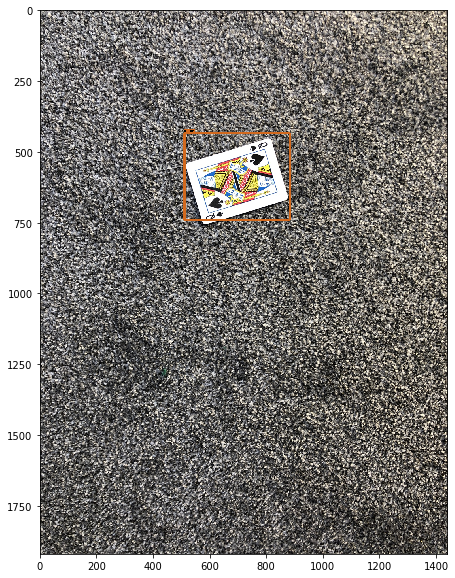

In [7]:
%matplotlib inline
image = Image.open('Live_Photo_Test/Q/Image 3.jpeg')
# the array based representation of the image will be used later in order to prepare the
# result image with boxes and labels on it.
image_np = load_image_into_numpy_array(image)
# Expand dimensions since the model expects images to have shape: [1, None, None, 3]
image_np_expanded = np.expand_dims(image_np, axis=0)
# Actual detection.
output_dict = run_inference_for_single_image(image_np, detection_graph)
# Visualization of the results of a detection.
vis_util.visualize_boxes_and_labels_on_image_array(
  image_np,
  output_dict['detection_boxes'],
  output_dict['detection_classes'],
  output_dict['detection_scores'],
  category_index,
  instance_masks=output_dict.get('detection_masks'),
  use_normalized_coordinates=True,
  line_thickness=8)
plt.figure(figsize=(20, 10))
plt.imshow(image_np)

print('Confidence Score', output_dict['detection_scores'][0])
print('Predicted Class', category_index[output_dict['detection_classes'][0]]['name'])

# Test Images on Unseen Virtually Created data set
Note: Takes a while to run

In [77]:
#Run on all images and compile outputs

correct_class = []
predicted_class = []

#classes = listdir('Fresh_Test/')
#classes = classes[1:]

classes = ['A','2','3','4','5','6','7','8','9','10','J','Q','K']

for class_folder in classes:
    files = listdir('Fresh_Test/'+class_folder+'/')
    for file in files:
        correct_class.append(class_folder)
        image = Image.open('Fresh_Test/'+class_folder+'/'+file)
        image_np = load_image_into_numpy_array(image)
        image_np_expanded = np.expand_dims(image_np, axis=0)
        output_dict = run_inference_for_single_image(image_np, detection_graph)
        main_detection_score = output_dict['detection_scores'][0]
        detected_class = category_index[output_dict['detection_classes'][0]]['name']
        predicted_class.append(detected_class)

    print('complete')

complete
complete
complete
complete
complete
complete
complete
complete
complete
complete
complete
complete
complete


In [78]:
correct_class1 = correct_class.copy()
predicted_class1 = predicted_class.copy()

In [11]:
from sklearn.metrics import confusion_matrix

In [80]:
f = confusion_matrix(correct_class, predicted_class, normalize='true')

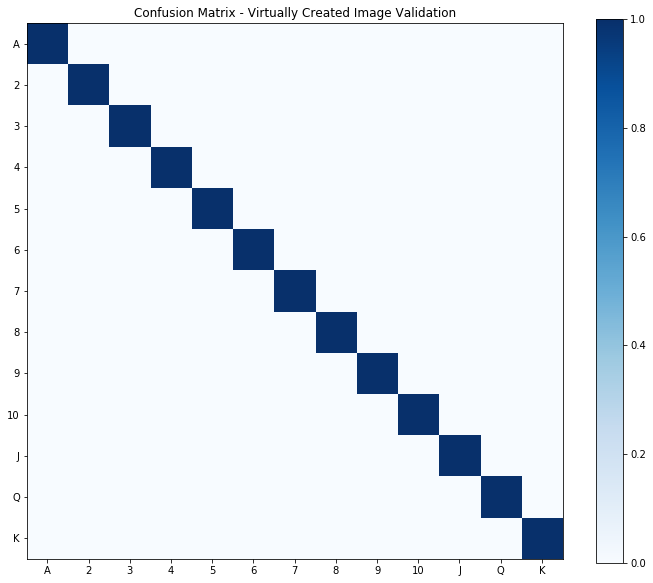

In [81]:
fig, ax = plt.subplots(figsize=(12,10))
im = ax.imshow(f, cmap='Blues')
ax.set_xticks([0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12])
ax.set_yticks([0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12])
ax.set_xticklabels(classes)
ax.set_yticklabels(classes)

ax.set_title('Confusion Matrix - Virtually Created Image Validation')

fig.colorbar(im)

plt.show()

In [82]:
#Store outputs in a csv file

store = 0

correct_class = np.array(correct_class)
predicted_class = np.array(predicted_class)

accuracy = []

for i in range(len(correct_class)):
    if correct_class[i] == predicted_class[i]:
        accuracy.append(1)
    else: accuracy.append(0)

accuracy = np.array(accuracy)

class_final = []
class_final_score = []
for i in classes:
    class_final.append(i)

    results = accuracy[correct_class == i]

    class_final_score.append(np.sum(results)/len(results))

final = []

for i in range(len(class_final)):
    a = [class_final[i], class_final_score[i]]
    final.append(a)


data = pd.DataFrame(final, columns=['Class', 'Score'])

if store == 1:
    data.to_csv('Score Output.csv', index=False)

    
data

,Class,Score
0,A,1.0
1,2,1.0
2,3,1.0
3,4,1.0
4,5,1.0
5,6,1.0
6,7,1.0
7,8,1.0
8,9,1.0
9,10,1.0


# Test images on real life photos
Note: Takes a while to run

In [8]:
classes = ['A','2','3','4','5','6','7','8','9','10','J','Q','K']

In [9]:
#Run on all images and compile outputs

correct_class = []
predicted_class = []


#classes = listdir('Live_Photo_Test/')
#classes = np.array(classes)
#classes = classes[classes != '.DS_Store']
    
classes = ['A','2','3','4','5','6','7','8','9','10','J','Q','K']   
    
for class_folder in classes:
    files = listdir('Live_Photo_Test/'+class_folder+'/')
    files = np.array(files)
    files = files[files != '.DS_Store']
    for file in files:
        correct_class.append(class_folder)
        image = Image.open('Live_Photo_Test/'+class_folder+'/'+file)
        image_np = load_image_into_numpy_array(image)
        image_np_expanded = np.expand_dims(image_np, axis=0)
        output_dict = run_inference_for_single_image(image_np, detection_graph)
        main_detection_score = output_dict['detection_scores'][0]
        detected_class = category_index[output_dict['detection_classes'][0]]['name']
        predicted_class.append(detected_class)
    print('complete')

complete
complete
complete
complete
complete
complete
complete
complete
complete
complete
complete
complete
complete


In [12]:
f2 = confusion_matrix(correct_class, predicted_class, normalize='true')

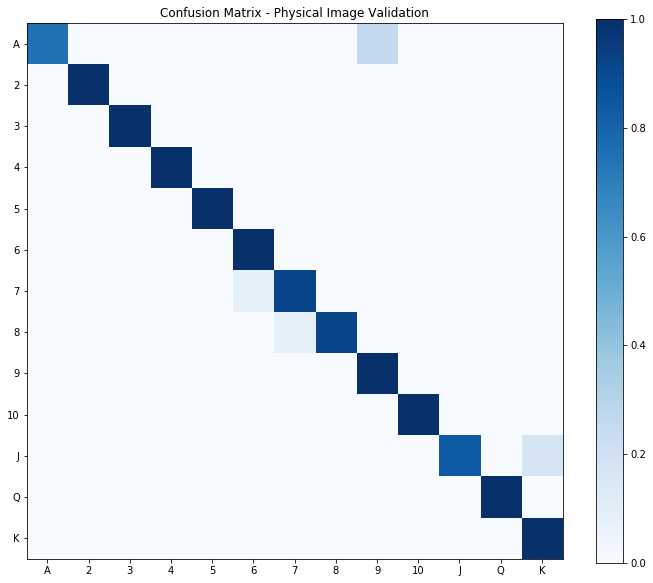

In [13]:
fig, ax = plt.subplots(figsize=(12,10))
im = ax.imshow(f2, cmap='Blues')
ax.set_xticks([0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12])
ax.set_yticks([0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12])
ax.set_xticklabels(classes)
ax.set_yticklabels(classes)

ax.set_title('Confusion Matrix - Physical Image Validation')

fig.colorbar(im)

plt.show()

In [14]:
store = 0


correct_class = np.array(correct_class)
predicted_class = np.array(predicted_class)

accuracy = []

for i in range(len(correct_class)):
    if correct_class[i] == predicted_class[i]:
        accuracy.append(1)
    else: accuracy.append(0)

accuracy = np.array(accuracy)

class_final = []
class_final_score = []
for i in classes:
    class_final.append(i)

    results = accuracy[correct_class == i]

    class_final_score.append(np.sum(results)/len(results))

final = []

for i in range(len(class_final)):
    a = [class_final[i], class_final_score[i]]
    final.append(a)

    data = pd.DataFrame(final, columns=['Class', 'Score'])
if store == 1:
    data.to_csv('Score Output - Live Photos.csv', index=False)
    
data

,Class,Score
0,A,1.000000
1,2,1.000000
2,3,1.000000
3,4,1.000000
4,5,1.000000
5,6,1.000000
6,7,0.916667
7,8,0.916667
8,9,1.000000
9,10,0.750000


In [15]:
classes

['A', '2', '3', '4', '5', '6', '7', '8', '9', '10', 'J', 'Q', 'K']

In [29]:
classes_dict = {}
classes_dict_rev = {}

for i in range(len(classes)):
    classes_dict[classes[i]] = i
    classes_dict_rev[i] = classes[i]

In [20]:
classes_dict

{'A': 0,
 '2': 1,
 '3': 2,
 '4': 3,
 '5': 4,
 '6': 5,
 '7': 6,
 '8': 7,
 '9': 8,
 '10': 9,
 'J': 10,
 'Q': 11,
 'K': 12}

In [26]:
conf_m = np.zeros((13, 13))

In [35]:
for i in range(len(correct_class)):
    crr = classes_dict[correct_class[i]]
    prd = classes_dict[predicted_class[i]]
    conf_m[crr][prd] += 1

In [36]:
conf_m

array([[12.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
       [ 0., 12.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
       [ 0.,  0., 12.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
       [ 0.,  0.,  0., 12.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
       [ 0.,  0.,  0.,  0., 12.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
       [ 0.,  0.,  0.,  0.,  0., 12.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
       [ 0.,  0.,  0.,  0.,  0.,  1., 11.,  0.,  0.,  0.,  0.,  0.,  0.],
       [ 0.,  0.,  0.,  0.,  0.,  0.,  1., 11.,  0.,  0.,  0.,  0.,  0.],
       [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0., 12.,  0.,  0.,  0.,  0.],
       [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  3.,  9.,  0.,  0.,  0.],
       [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0., 10.,  2.,  0.],
       [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0., 12.,  0.],
       [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0., 12.]])

In [50]:
conf_m_perc = np.zeros((13, 13))

for i in range(conf_m.shape[0]):
    s = np.sum(conf_m[i])
    for x in range(conf_m.shape[1]):
        conf_m_perc[i][x] = conf_m[i][x] / s
    
conf_m_perc 

array([[1.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        ],
       [0.        , 1.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        ],
       [0.        , 0.        , 1.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        ],
       [0.        , 0.        , 0.        , 1.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        ],
       [0.        , 0.        , 0.        , 0.        , 1.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        ],
       [0.        , 0.        , 0.        , 0.        , 0.        ,
        1.        , 0.     

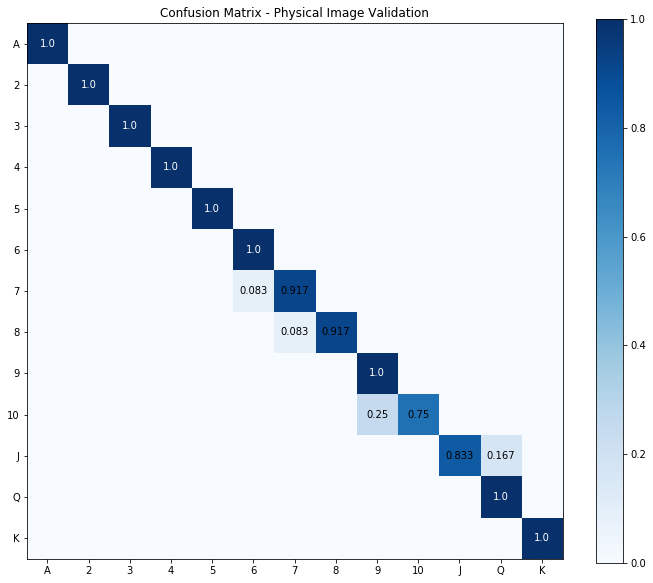

In [66]:
fig, ax = plt.subplots(figsize=(12,10))
im = ax.imshow(conf_m_perc, cmap='Blues')
ax.set_xticks([0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12])
ax.set_yticks([0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12])
ax.set_xticklabels(classes)
ax.set_yticklabels(classes)

ax.set_title('Confusion Matrix - Physical Image Validation')

for i in range(len(classes)):
    for j in range(len(classes)):
        
        if conf_m_perc[i, j] == 1:
            text = ax.text(j, i, round(conf_m_perc[i, j],3),
                          ha="center", va="center", color="w")
            
        if conf_m_perc[i, j] < 1:
            if conf_m_perc[i, j] > 0:
                text = ax.text(j, i, round(conf_m_perc[i, j],3),
                              ha="center", va="center")
        
fig.colorbar(im)

plt.show()